In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My Drive/food_review

/content/gdrive/My Drive/food_review


#<b>1.Importing Required Pakcages

In [ ]:
#Still need to check about outliers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
from tqdm import tqdm
from datetime import datetime
import pickle
from scipy.sparse import save_npz,load_npz

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import download,pos_tag,word_tokenize

from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import roc_auc_score,roc_curve,auc,plot_confusion_matrix,accuracy_score

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from scipy.sparse import hstack,coo_matrix

from imblearn.over_sampling import SMOTE

%matplotlib inline

download('wordnet')
download('punkt')
download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#<b>2.EDA

##<b>2.1 Loading Dataset 

In [ ]:
data = pd.read_csv('Reviews.csv')

In [ ]:
data.head()

Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...
3   4  ...  If you are looking for the secret ingredient i...
4   5  ...  Great taffy at a great price.  There was a wid...

[5 rows x 10 columns]

In [ ]:
print("Data size : ",data.shape)

Data size :  (568454, 10)


##<b>2.2 Sampling Dataset

<h1>566k rows are too much for processing so we are sampling 100k values randomly from the dataset

In [ ]:
data = data.sample(n=100000)
print("Data size : ",data.shape)

Data size :  (100000, 10)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 524199 to 476426
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      100000 non-null  int64 
 1   ProductId               100000 non-null  object
 2   UserId                  100000 non-null  object
 3   ProfileName             99998 non-null   object
 4   HelpfulnessNumerator    100000 non-null  int64 
 5   HelpfulnessDenominator  100000 non-null  int64 
 6   Score                   100000 non-null  int64 
 7   Time                    100000 non-null  int64 
 8   Summary                 99995 non-null   object
 9   Text                    100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 8.4+ MB


In [ ]:
data.drop(['Id'],inplace=True,axis=1)
data.drop(['Time'],inplace=True,axis=1)

In [ ]:
print("Number of unique users : "+str(len(data['ProfileName'].unique())))

Number of unique users : 64481


In [ ]:
print("Number of unique products : "+str(len(data['ProductId'].unique())))

Number of unique products : 31624


##<b>2.3 Processing missing and duplicate values

###<b>2.3.1 Processing missing values and duplicate values

In [ ]:
data.isnull().sum()

ProductId                 0
UserId                    0
ProfileName               2
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Summary                   5
Text                      0
dtype: int64

<h1>As we can see that missing values are very low in number compaired to our dataset so we can drop the rows containing missing values</h1>

In [ ]:
data = data.dropna()

In [ ]:
data.isnull().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Summary                   0
Text                      0
dtype: int64

###<b>2.3.2 Processing duplicate values

In [ ]:
data[data.duplicated()]

ProductId  ...                                               Text
216154  B001BORBM4  ...  My dog seems to be allergic to poultry so we t...
493084  B003TC7WN4  ...  First, let me say that I prefer extra-bold K-C...
8523    B003VXFK44  ...  First, let me say that I prefer extra-bold K-C...
255265  B0029NVJX8  ...  These treats are my picky cat's favorite.  I'v...
139607  B001BCXTGS  ...  My two traditional striped cats eat mostly dry...
312911  B001NXM3GM  ...  These Puffs are great and my son loves them. T...
235297  B0034EDMCW  ...  The Kind bars are just too sweet for me. But I...
98163   B0030VJ70K  ...  My kids (18 mo and 3 yrs) love the HappyBaby T...
420117  B000FPM22O  ...  My little one loves these and you cannot beat ...
449364  B0024EA8DE  ...  First Impression: The friendly folks over at "...
297794  B0007LXU1I  ...  All Natural<br /><br />  * Protein 13g<br /><b...
235815  B0019Z463M  ...  Charlee Bears are small and low calorie, so yo...
217557  B0002DJNNK  ...  First Impression: The friendly folks over at "...
452518  B000YSTGGW  ...  This is a great cereal and with added Probioti...
496514  B001181NBA  ...  if you are looking for a protein bar that does...
171152  7310172001  ...  Freeze dried liver has a hypnotic effect on do...

[16 rows x 8 columns]

<h1>We will drop these duplicate values in the dataset

In [ ]:
data.drop_duplicates(keep='first',inplace=True)

In [ ]:
data[data.duplicated()]

Empty DataFrame
Columns: [ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Summary, Text]
Index: []

##<b>2.4 Setting the target variable

In [ ]:
target = data['Score']

<h1> Checking distribution of target variable in the dataset

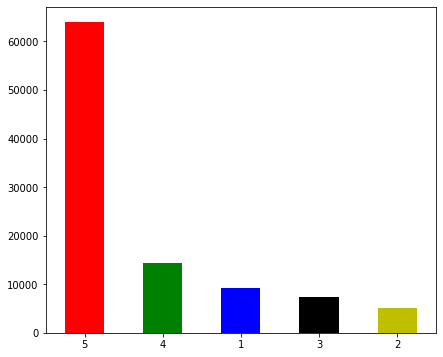

In [ ]:
target.value_counts().plot(kind='bar',figsize=(7, 6), rot=0,color= list('rgbkymc'))

<h1>We will consider score of 1 & 2 as negative and 3,4,5 as positive

In [ ]:
target = target.apply(lambda x: 1 if x>3 else 0)

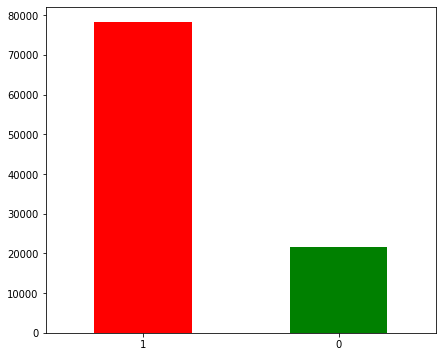

In [ ]:
target.value_counts().plot(kind='bar',figsize=(7, 6), rot=0,color= list('rgbkymc'))

<h1>We can observe here that classes are highly imbalanced

In [ ]:
#replacing score with binary class in the dataset
data['Score'] = target

In [ ]:
data['ProfileName'].value_counts()

O. Brown "Ms. O. Khannah-Brown"           80
C. F. Hill "CFH"                          79
Chris                                     76
Gary Peterson                             73
Rebecca of Amazon "The Rebecca Review"    61
                                          ..
K123                                       1
Malvin                                     1
Dogfarmer "Dogfarmer"                      1
shepherd girl                              1
Luisa                                      1
Name: ProfileName, Length: 64479, dtype: int64

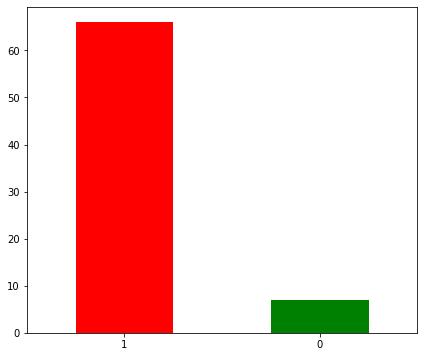

In [ ]:
data.loc[data['ProfileName']=='Gary Peterson']['Score'].value_counts().plot(kind='bar',figsize=(7, 6), rot=0,color= list('rgbkymc'))

#<b>2.5 Text Preprocessing

###<b>2.5.1 Creating list of Stopwords

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you'
"you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he'
'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its',
'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because'
'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into'
'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on',
'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than'
's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've"
've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn'
"hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
"mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't"
'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
#utility function for cleaning the text 

def text_preprocessing(text):

  #Removing HTML tags
  #https://stackoverflow.com/a/12982689
  cleanr = re.compile('<.*?>')
  clean_text = re.sub(cleanr, '', text)
  
  #Removing abbreviations 
  # https://stackoverflow.com/a/47091490/4084039
  # specific
  clean_text = re.sub(r"won't", "will not", clean_text)
  clean_text = re.sub(r"can\'t", "can not", clean_text)
  # general
  clean_text = re.sub(r"n\'t", " not", clean_text)
  clean_text = re.sub(r"\'re", " are", clean_text)
  clean_text = re.sub(r"\'s", " is", clean_text)
  clean_text = re.sub(r"\'d", " would", clean_text)
  clean_text = re.sub(r"\'ll", " will", clean_text)
  clean_text = re.sub(r"\'t", " not", clean_text)
  clean_text = re.sub(r"\'ve", " have", clean_text)
  clean_text = re.sub(r"\'m", " am", clean_text)
  
  # \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-py
  clean_text = clean_text.replace('\\r', ' ')
  clean_text = clean_text.replace('\\"', ' ')
  clean_text = clean_text.replace('\\n', ' ')

  #remove spacial character: https://stackoverflow.com/a/5843547/4084039
  clean_text = re.sub('[^A-Za-z0-9]+', ' ', clean_text)
  
  #changing casing of all text to lower
  clean_text = " ".join([word.lower().strip() for word in clean_text.split()])

  #stop word removal : # https://gist.github.com/sebleier/554280
  clean_text = ' '.join([e for e in clean_text.split() if e.strip() not in stopwords])

  return clean_text

###<b>2.5.2 Preprocessing Summary

In [ ]:
data['PreprocessedSummary'] = data['Summary'].apply(text_preprocessing)
data.drop(['Summary'],axis=1,inplace=True)

###<b>2.5.3 Preprocessing Text

In [ ]:
data['PreprocessedText'] = data['Text'].apply(text_preprocessing)
data.drop(['Text'],axis=1,inplace=True)

###<b>2.5.4 Creating function for lemmatizing text data

In [ ]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = pos_tag(word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

###<b>2.5.5 Lemmatizing Summary

In [ ]:
data['PreprocessedSummary'] = data['PreprocessedSummary'].apply(lemmatize_sentence)

###<b>2.5.6 Lemmatizing Text

In [ ]:
data['PreprocessedText'] = data['PreprocessedText'].apply(lemmatize_sentence)

##<b>2.6 Creating Word Cloud 

###<b>2.6.1 Word Cloud of text data of the user with highest number of reviews

In [ ]:
#https://www.datacamp.com/community/tutorials/wordcloud-python

stopwords = set(STOPWORDS)
stopwords.remove("not")
stopwords.remove("no")
print("Number of stopwords : "+str(len(stopwords)))
print(stopwords)

Number of stopwords : 188
{"how's", 'a', 'again', "why's", 'during', "he'd", "i'll", 'this', "shouldn't", 'was', "you're", 'such', "they'd", 'www', 'but', "who's", "you'll", "you've", 'should', 'myself', 'each', 'that', 'itself', 'when', 'he', 'herself', 'she', 'ought', 'than', 'your', 'yourself', "hadn't", "what's", 'am', "that's", "he'll", 'most', 'some', "let's", 'or', 'by', 'over', 'both', 'so', 'on', 'where', 'does', 'him', 'nor', 'with', "we're", 'for', 'down', "she'd", 'about', 'their', 'you', "we've", "haven't", 'ourselves', 'why', 'otherwise', 'yourselves', 'could', 'own', "weren't", 'because', 'doing', 'what', 'however', 'very', 'can', 'whom', "i'm", 'off', 'in', 'be', 'his', 'being', 'how', "we'll", "they'll", 'then', "you'd", 'above', 'few', 'just', 'are', 'under', 'would', 'also', "they've", 'her', 'since', 'to', 'the', 'once', 'which', 'further', 'r', 'get', 'have', 'its', 'my', 'same', "shan't", 'below', "doesn't", "here's", 'other', 'of', "we'd", 'himself', 'if', 'our',

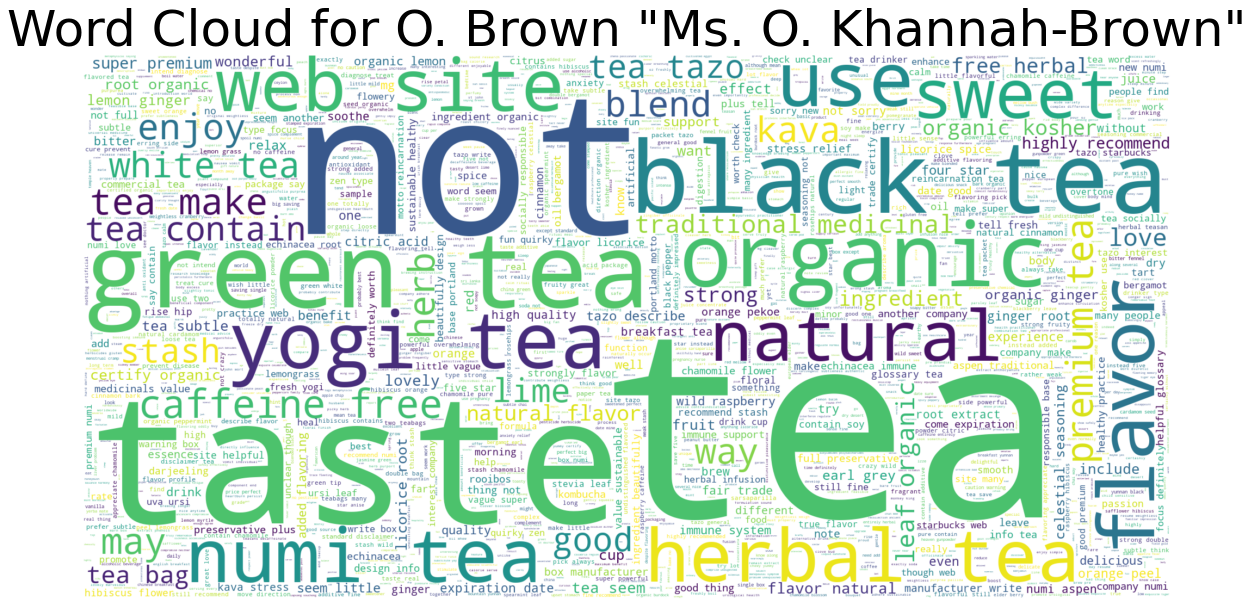

In [ ]:
text = " ".join(review for review in data.loc[data['ProfileName']=='O. Brown "Ms. O. Khannah-Brown"',['PreprocessedText']].PreprocessedText)
wc = WordCloud(background_color="white", max_words=len(text),width=2000, height=1000, stopwords=stopwords)
wc.generate(text)
plt.figure( figsize=(20,10) )
plt.title('Word Cloud for O. Brown "Ms. O. Khannah-Brown"',fontsize=50)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

###<b>2.6.2 Word Cloud of Summary data of the user with highest number of reviews

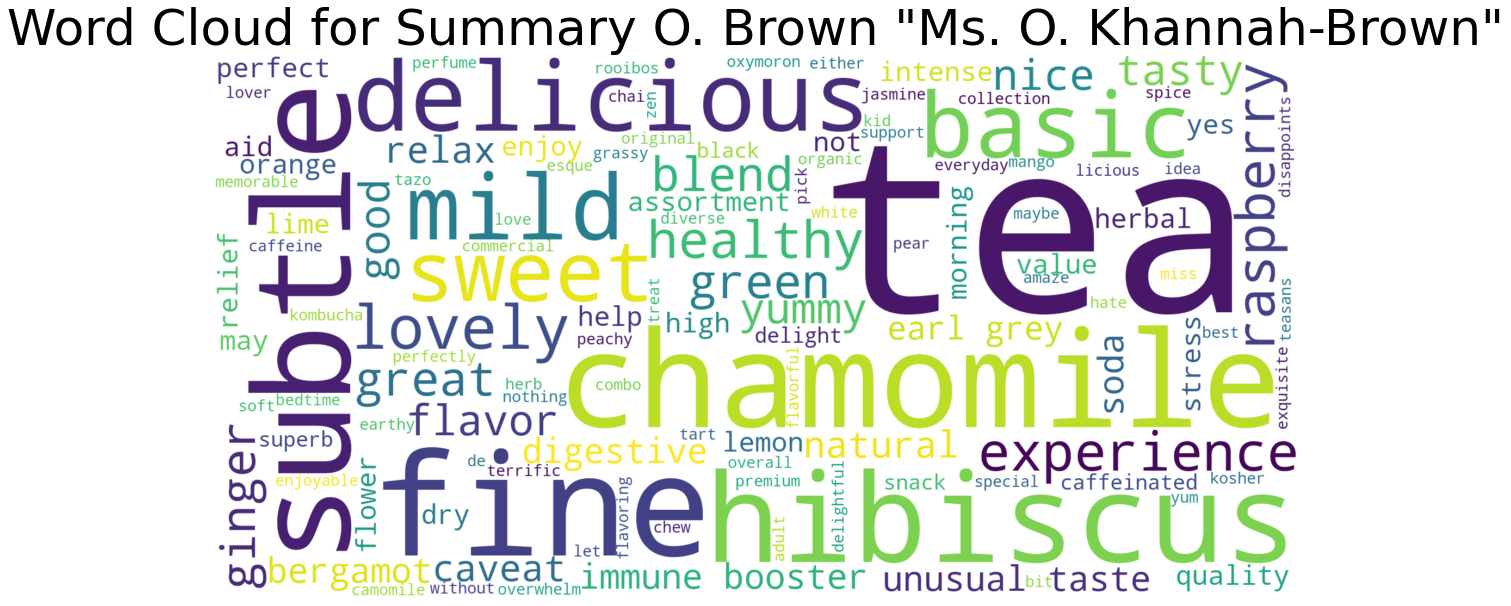

In [ ]:
text = " ".join(review for review in data.loc[data['ProfileName']=='O. Brown "Ms. O. Khannah-Brown"',['PreprocessedSummary']].PreprocessedSummary)
wc = WordCloud(background_color="white", max_words=len(text),width=2000, height=1000, stopwords=stopwords)
wc.generate(text)
# print ('Word Cloud for Summary of O. Brown "Ms. O. Khannah-Brown"')
plt.figure( figsize=(20,10) )
plt.title('Word Cloud for Summary O. Brown "Ms. O. Khannah-Brown"',fontsize=50)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

###<b>2.6.3 Word Cloud of text data of the positive reviews

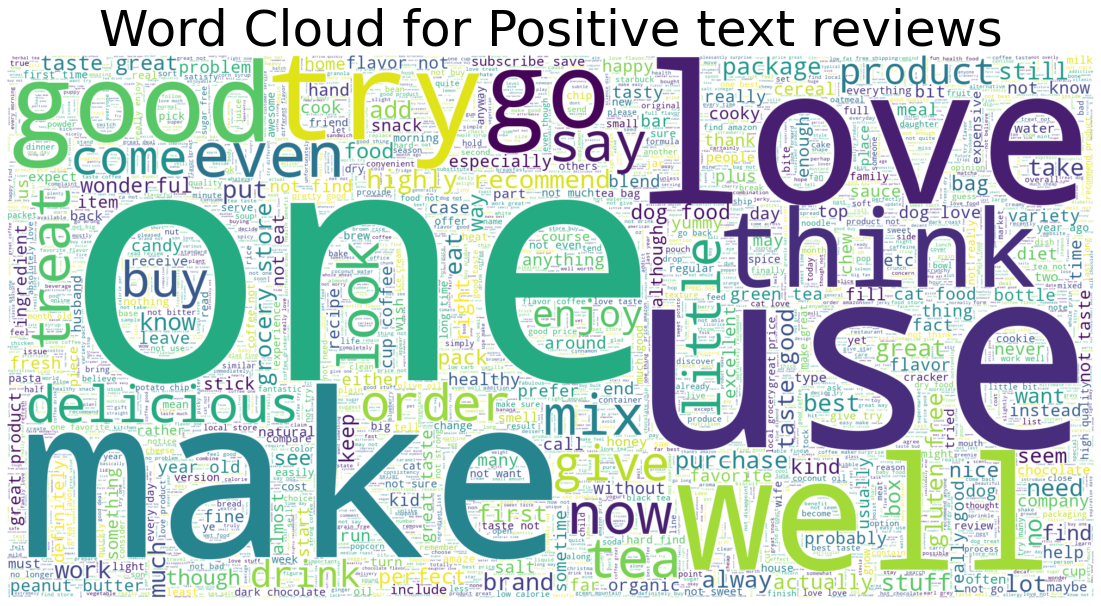

In [ ]:
text = " ".join(review for review in data.loc[data['Score']==1,['PreprocessedText']].PreprocessedText)
wc = WordCloud(background_color="white", max_words=len(text),width=2000, height=1000, stopwords=stopwords)
wc.generate(text)
# print ("Word Cloud for Positive Text")
plt.figure( figsize=(20,10) )
plt.title('Word Cloud for Positive text reviews',fontsize=50)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

###<b>2.6.4 Word Cloud of text data of the negative reviews

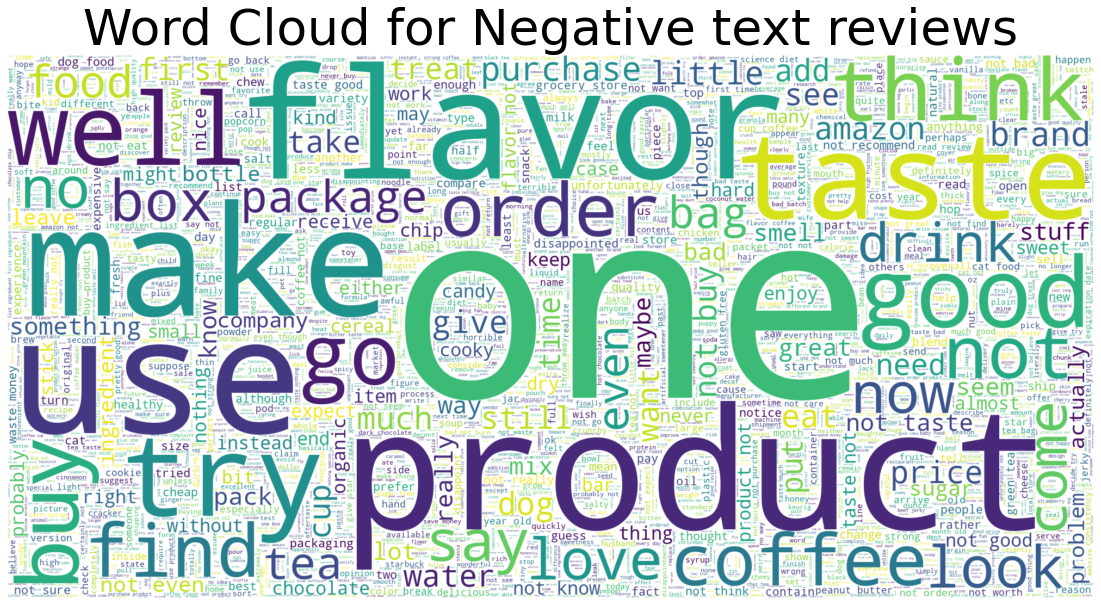

In [ ]:
text = " ".join(review for review in data.loc[data['Score']==0,['PreprocessedText']].PreprocessedText)
wc = WordCloud(background_color="white", max_words=len(text),width=2000, height=1000, stopwords=stopwords)
wc.generate(text)
# print ("Word Cloud for Negative Text")
plt.figure( figsize=(20,10) )
plt.title('Word Cloud for Negative text reviews',fontsize=50)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

###<b>2.6.5 Word Cloud of Summary data of the positive reviews

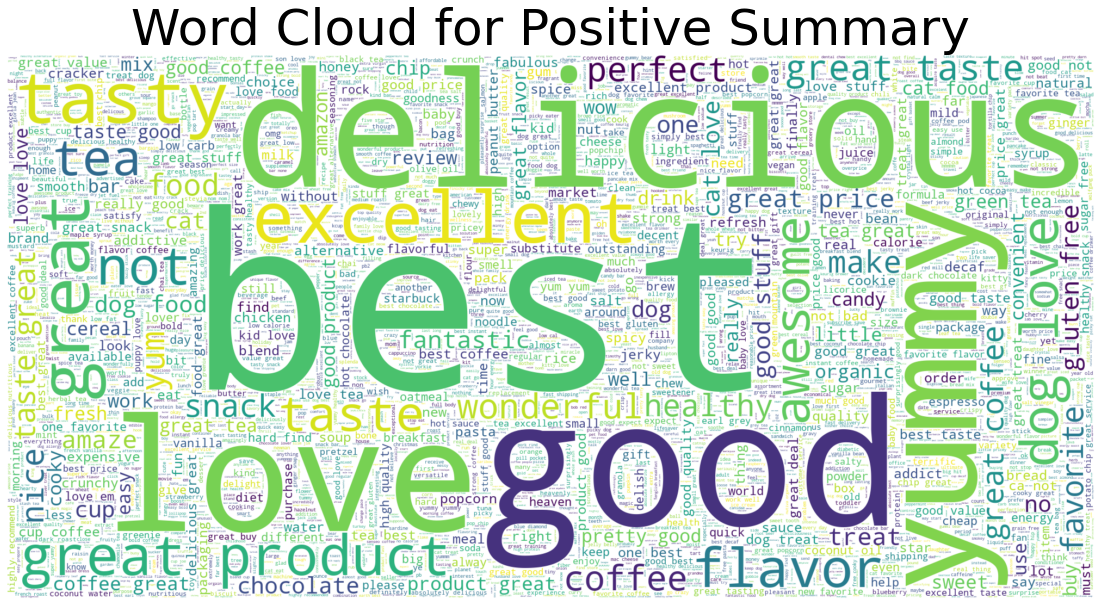

In [ ]:
text = " ".join(review for review in data.loc[data['Score']==1,['PreprocessedSummary']].PreprocessedSummary)
wc = WordCloud(background_color="white", max_words=len(text),width=2000, height=1000, stopwords=stopwords)
wc.generate(text)
# print ("Word Cloud for Positive Summary")
plt.figure( figsize=(20,10) )
plt.title('Word Cloud for Positive Summary',fontsize=50)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

###<b>2.6.6 Word Cloud of Summary data of the negative reviews

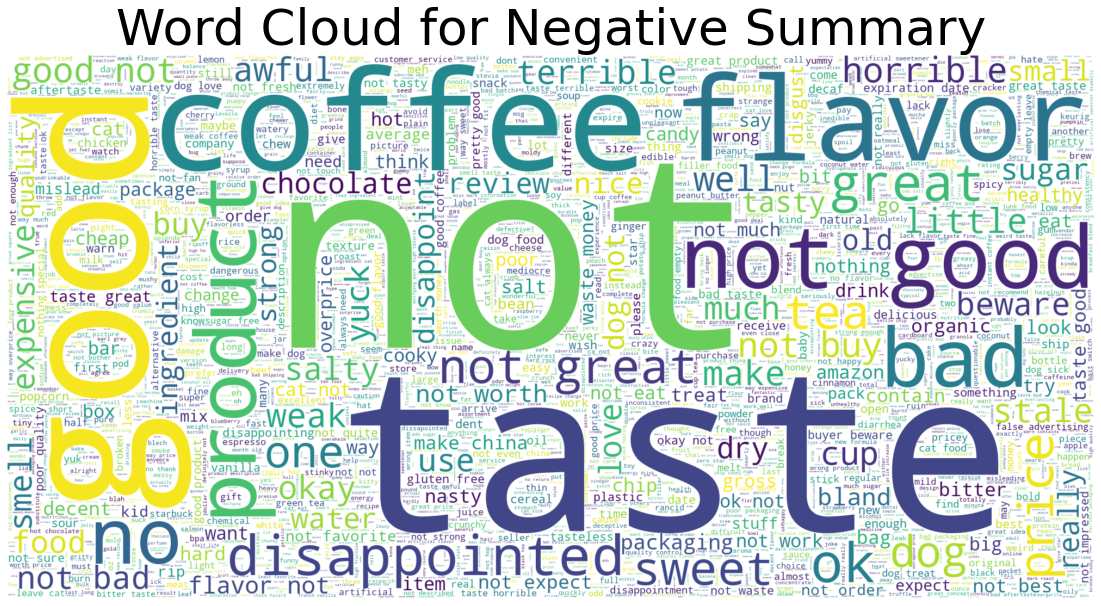

In [ ]:
text = " ".join(review for review in data.loc[data['Score']==0,['PreprocessedSummary']].PreprocessedSummary)
wc = WordCloud(background_color="white", max_words=len(text),width=2000, height=1000, stopwords=stopwords)
wc.generate(text)
# print ("Word Cloud for Negative Summary")
plt.figure( figsize=(20,10) )
plt.title('Word Cloud for Negative Summary',fontsize=50)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

##<b>2.7 Increasing weight of Summary

<h1> As we can see , Summary has more prominent words to divide the classess efectively so we will increase the weight of summary 

In [ ]:
def adding_summary_weight(text):
  return " ".join([text]*3)

In [ ]:
data['PreprocessedSummary'] = data['PreprocessedSummary'].apply(adding_summary_weight)

#<b> 3. Feature Engineering

##<b>3.1 Creating a new feature 'HelpfullnessRatio' as ratio of upvotes and downvotes of of a review

In [ ]:
data['HelpfulnessNumerator'].value_counts()

0      53529
1      20411
2       9548
3       5056
4       2976
       ...  
138        1
74         1
294        1
137        1
488        1
Name: HelpfulnessNumerator, Length: 136, dtype: int64

In [ ]:
data['HelpfulnessDenominator'].value_counts()

0      47624
1      19784
2      10809
3       6011
4       3926
       ...  
162        1
99         1
200        1
401        1
383        1
Name: HelpfulnessDenominator, Length: 136, dtype: int64

In [ ]:
ratios = []

for numerator,denominator in tqdm(zip(data['HelpfulnessNumerator'].values,data['HelpfulnessDenominator'].values)):
  if numerator!=0 and denominator!=0:
    ratios.append(numerator/denominator) 
  elif numerator == 0 and denominator!=0:
    ratios.append(-denominator)
  elif numerator!=0 and denominator == 0:
    ratios.append(numerator)
  else:
    ratios.append(0)

99977it [00:00, 655200.05it/s]


In [ ]:
data['HelpfullnessRatio'] = np.array(ratios)

In [ ]:
data['HelpfullnessRatio'].value_counts()

 0.000000    47624
 1.000000    32262
-1.000000     3907
 0.500000     3724
 0.666667     1842
             ...  
 0.392857        1
 0.086207        1
 0.768293        1
 0.210526        1
 0.987342        1
Name: HelpfullnessRatio, Length: 498, dtype: int64

##<b>3.2 Creating a new feature 'TextLength' as length of text of a review

In [ ]:
data['TextLength'] = data['PreprocessedText'].apply(len)

##<b>3.3 Creating a new feature 'SummaryLength' as length of summary of a review

In [ ]:
data['SummaryLength'] = data['PreprocessedSummary'].apply(len)

##<b>3.4 Plotting Correlation Matrix with numerical features

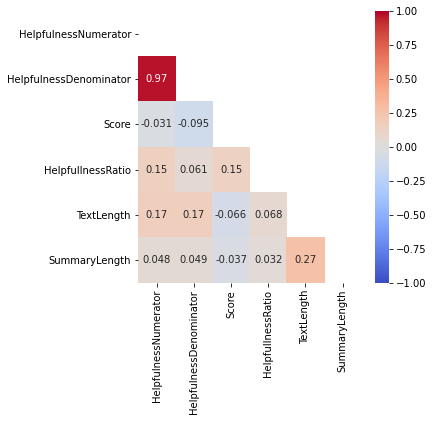

In [ ]:
#https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07

mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,5))
sns.heatmap(data.corr(),cmap='coolwarm',annot=True,fmt='.2g',vmin=-1,vmax=1, center= 0,mask = mask);

In [ ]:
data['HelpfulnessNumerator'].corr(data['HelpfulnessDenominator'])

0.9709711707507088

<h1> As we can see there is high correlation among two features so we will drop one of them having lower correalation with target variable

In [ ]:
data.drop('HelpfulnessNumerator',axis=1,inplace=True)

#<b> 3. Feature Standardization and Vectorization

##<b> 3.1 Splitting the data

In [ ]:
data.drop(['ProductId','UserId','ProfileName','Score'],axis=1,inplace=True)

In [ ]:
Y = target.values
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.33, stratify=Y)

In [ ]:
print("shape of train features and target:",X_train.shape,Y_train.shape)
print("shape of test features and target:",X_test.shape,Y_test.shape)

shape of train features and target: (66984, 6) (66984,)
shape of test features and target: (32993, 6) (32993,)


##<b> 3.2 Standardizing numerical data

In [ ]:
numerical_scalar = StandardScaler()
numerical_scalar = numerical_scalar.fit(X_train[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']])

In [ ]:
X_train[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']] = numerical_scalar.transform(X_train[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']])
X_test[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']] = numerical_scalar.transform(X_test[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [ ]:
X_train.columns

Index(['HelpfulnessDenominator', 'PreprocessedSummary', 'PreprocessedText',
       'HelpfullnessRatio', 'TextLength', 'SummaryLength'],
      dtype='object')

In [ ]:
coulumn_list_bow = X_train.columns.to_list()
coulumn_list_tfidf = X_train.columns.to_list()

In [ ]:
X_train.head()

HelpfulnessDenominator  ... SummaryLength
84736                -0.147231  ...     -0.156370
312833               -0.270348  ...     -0.795573
152249               -0.147231  ...      2.217813
374634               -0.270348  ...     -0.065055
340213               -0.147231  ...      0.391519

[5 rows x 6 columns]

##<b> 3.3 Vectorizing text and summary features

###<b> 3.3.1 Vectorizing using BOW

In [ ]:
summary_vectorizer_ohe = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)

summary_vectorizer_ohe = summary_vectorizer_ohe.fit(X_train['PreprocessedSummary'].values)

X_train_PreprocessedSummary_ohe = summary_vectorizer_ohe.transform(X_train['PreprocessedSummary'].values)
X_test_PreprocessedSummary_ohe = summary_vectorizer_ohe.transform(X_test['PreprocessedSummary'].values)

coulumn_list_bow.extend(summary_vectorizer_ohe.get_feature_names())

print("Shape of train summary after vectorization : ",X_train_PreprocessedSummary_ohe.shape)
print("Shape of test summary after vectorization : ",X_test_PreprocessedSummary_ohe.shape)

Shape of train summary after vectorization :  (66984, 4288)
Shape of test summary after vectorization :  (32993, 4288)


In [ ]:
freqs = zip(summary_vectorizer_ohe.get_feature_names(), X_train_PreprocessedSummary_ohe.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:10]

[('great', 26316),
 ('good', 19362),
 ('not', 16089),
 ('love', 13209),
 ('best', 12201),
 ('taste', 10179),
 ('coffee', 8793),
 ('tea', 8322),
 ('product', 7506),
 ('of', 7239)]

In [ ]:
freqs = zip(summary_vectorizer_ohe.get_feature_names(), X_test_PreprocessedSummary_ohe.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:10]

[('great', 12498),
 ('good', 9738),
 ('not', 8004),
 ('love', 6651),
 ('best', 5748),
 ('taste', 5160),
 ('coffee', 4347),
 ('tea', 3876),
 ('dog', 3840),
 ('product', 3627)]

In [ ]:
text_vectorizer_ohe = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)

text_vectorizer_ohe = text_vectorizer_ohe.fit(X_train['PreprocessedText'].values)

X_train_PreprocessedText_ohe = text_vectorizer_ohe.transform(X_train['PreprocessedText'].values)
X_test_PreprocessedText_ohe = text_vectorizer_ohe.transform(X_test['PreprocessedText'].values)

coulumn_list_bow.extend(text_vectorizer_ohe.get_feature_names())

print("Shape of train summary after vectorization : ",X_train_PreprocessedText_ohe.shape)
print("Shape of test summary after vectorization : ",X_test_PreprocessedText_ohe.shape)

Shape of train summary after vectorization :  (66984, 5000)
Shape of test summary after vectorization :  (32993, 5000)


In [ ]:
freqs = zip(text_vectorizer_ohe.get_feature_names(), X_train_PreprocessedText_ohe.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:20]

[('of', 93232),
 ('not', 75431),
 ('that', 52788),
 ('you', 43061),
 ('they', 36531),
 ('like', 33023),
 ('have', 33014),
 ('as', 32787),
 ('taste', 30486),
 ('do', 29422),
 ('good', 27721),
 ('these', 27106),
 ('them', 24610),
 ('flavor', 24099),
 ('one', 22453),
 ('love', 21763),
 ('get', 21658),
 ('product', 21471),
 ('at', 20807),
 ('coffee', 20543)]

In [ ]:
freqs = zip(text_vectorizer_ohe.get_feature_names(), X_test_PreprocessedText_ohe.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:20]

[('of', 46496),
 ('not', 37474),
 ('that', 26119),
 ('you', 21541),
 ('they', 18510),
 ('have', 16551),
 ('as', 16483),
 ('like', 16457),
 ('do', 14822),
 ('taste', 14767),
 ('good', 13911),
 ('these', 13509),
 ('them', 12174),
 ('flavor', 11909),
 ('one', 11342),
 ('get', 10841),
 ('love', 10677),
 ('product', 10649),
 ('at', 10521),
 ('coffee', 10197)]

###<b> 3.3.2 Vectorizing using tfidf

In [ ]:
summary_vectorizer_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)

summary_vectorizer_tfidf = summary_vectorizer_tfidf.fit(X_train['PreprocessedSummary'].values)

X_train_PreprocessedSummary_tfidf = summary_vectorizer_tfidf.transform(X_train['PreprocessedSummary'].values)
X_test_PreprocessedSummary_tfidf = summary_vectorizer_tfidf.transform(X_test['PreprocessedSummary'].values)

coulumn_list_tfidf.extend(summary_vectorizer_tfidf.get_feature_names())

print("Shape of train summary after vectorization : ",X_train_PreprocessedSummary_tfidf.shape)
print("Shape of test summary after vectorization : ",X_test_PreprocessedSummary_tfidf.shape)

Shape of train summary after vectorization :  (66984, 4288)
Shape of test summary after vectorization :  (32993, 4288)


In [ ]:
freqs = zip(summary_vectorizer_tfidf.get_feature_names(), X_train_PreprocessedSummary_tfidf.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:10]

[('great', 2341.1400038022584),
 ('good', 1762.642668116976),
 ('love', 1556.7560501546402),
 ('not', 1302.059570312046),
 ('best', 1208.8891258898389),
 ('delicious', 1133.250605779587),
 ('taste', 997.4446683576284),
 ('coffee', 952.3872057311708),
 ('product', 916.8623481321099),
 ('tea', 908.1609954839462)]

In [ ]:
freqs = zip(summary_vectorizer_tfidf.get_feature_names(), X_test_PreprocessedSummary_tfidf.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:10]

[('great', 1129.1652958062655),
 ('good', 909.6975566244259),
 ('love', 795.5291054699619),
 ('not', 652.7656756985542),
 ('delicious', 580.3470091207819),
 ('best', 576.9363363531285),
 ('taste', 511.0644313960816),
 ('coffee', 475.0431758265064),
 ('product', 444.58890996064105),
 ('tea', 424.95266523535685)]

In [ ]:
text_vectorizer_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)

text_vectorizer_tfidf = text_vectorizer_tfidf.fit(X_train['PreprocessedText'].values)

X_train_PreprocessedText_tfidf = text_vectorizer_tfidf.transform(X_train['PreprocessedText'].values)
X_test_PreprocessedText_tfidf = text_vectorizer_tfidf.transform(X_test['PreprocessedText'].values)

coulumn_list_tfidf.extend(text_vectorizer_tfidf.get_feature_names())

print("Shape of train summary after vectorization : ",X_train_PreprocessedText_tfidf.shape)
print("Shape of test summary after vectorization : ",X_test_PreprocessedText_tfidf.shape)

Shape of train summary after vectorization :  (66984, 5000)
Shape of test summary after vectorization :  (32993, 5000)


In [ ]:
freqs = zip(text_vectorizer_tfidf.get_feature_names(), X_train_PreprocessedText_tfidf.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:20]

[('of', 3054.2534502205463),
 ('not', 2753.5458709407503),
 ('that', 2068.7060948452286),
 ('you', 2043.5169576364167),
 ('they', 1931.8754833737487),
 ('taste', 1696.5135888879183),
 ('these', 1686.6912215505686),
 ('like', 1667.4691059870686),
 ('as', 1660.377146168616),
 ('good', 1617.5841073683891),
 ('have', 1610.760397202208),
 ('coffee', 1595.5741661303596),
 ('them', 1540.380375055196),
 ('love', 1498.9475113370966),
 ('great', 1477.3782500289872),
 ('flavor', 1467.7754884404833),
 ('do', 1455.4044325920831),
 ('tea', 1433.5896222817844),
 ('product', 1424.8693634350889),
 ('very', 1295.6240725616692)]

In [ ]:
freqs = zip(text_vectorizer_tfidf.get_feature_names(), X_test_PreprocessedText_tfidf.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:20]

[('of', 1519.5885207922834),
 ('not', 1358.4381936811737),
 ('that', 1022.2644831987217),
 ('you', 1011.4188916944144),
 ('they', 968.7597220286185),
 ('these', 836.2918142462827),
 ('as', 828.0712437134024),
 ('like', 826.7614778714311),
 ('taste', 823.88006179244),
 ('good', 807.0974334559079),
 ('have', 800.3482654250738),
 ('coffee', 785.9402060856387),
 ('them', 748.695731798298),
 ('love', 733.1149088387702),
 ('flavor', 731.6548474299452),
 ('do', 727.7242870568421),
 ('great', 713.2693373418589),
 ('product', 703.754099737718),
 ('tea', 703.0373359792395),
 ('very', 646.3768015246176)]

###<b> 3.3.3 Vectorizing using word2vec

In [ ]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
  print ("Loading Glove Model")
  f = open(gloveFile,'r', encoding="utf8")
  model = {}
  for line in tqdm(f):
    splitLine = line.split()
    word = splitLine[0]
    embedding = np.array([float(val) for val in splitLine[1:]])
    model[word] = embedding
  print ("Done.",len(model)," words loaded!")
  return model

model = loadGloveModel('glove.42B.300d.txt')
glove_words = set(model.keys())

0it [00:00, ?it/s]

Loading Glove Model


1917495it [04:08, 7713.70it/s]

Done. 1917495  words loaded!


In [ ]:
x_train_summary_avg_w2v = []

for sentence in tqdm(X_train['PreprocessedSummary'].values):
  w2v = np.zeros(300)
  count = 0

  for word in sentence.split():
    if word in glove_words:
      w2v += model[word]
      count += 1
  if count !=0 :
    w2v /= count

  x_train_summary_avg_w2v.append(w2v)

x_train_summary_avg_w2v = np.array(x_train_summary_avg_w2v)

100%|██████████| 66984/66984 [00:01<00:00, 39456.05it/s]


In [ ]:
x_test_summary_avg_w2v = []

for sentence in tqdm(X_test['PreprocessedSummary'].values):
  w2v = np.zeros(300)
  count = 0

  for word in sentence.split():
    if word in glove_words:
      w2v += model[word]
      count += 1
  if count !=0 :
    w2v /= count

  x_test_summary_avg_w2v.append(w2v)

x_test_summary_avg_w2v = np.array(x_test_summary_avg_w2v)

100%|██████████| 32993/32993 [00:00<00:00, 40548.05it/s]


In [ ]:
x_train_text_avg_w2v = []

for sentence in tqdm(X_train['PreprocessedText'].values):
  w2v = np.zeros(300)
  count = 0

  for word in sentence.split():
    if word in glove_words:
      w2v += model[word]
      count += 1
  if count !=0 :
    w2v /= count

  x_train_text_avg_w2v.append(w2v)

x_train_text_avg_w2v = np.array(x_train_text_avg_w2v)

100%|██████████| 66984/66984 [00:09<00:00, 7266.62it/s]


In [ ]:
x_test_text_avg_w2v = []

for sentence in tqdm(X_test['PreprocessedText'].values):
  w2v = np.zeros(300)
  count = 0

  for word in sentence.split():
    if word in glove_words:
      w2v += model[word]
      count += 1
  if count !=0 :
    w2v /= count

  x_test_text_avg_w2v.append(w2v)

x_test_text_avg_w2v = np.array(x_test_text_avg_w2v)

100%|██████████| 32993/32993 [00:04<00:00, 7077.85it/s]


###<b> 3.3.1 Vectorizing using tfidf-word2vec

In [ ]:
tfidf_summary = TfidfVectorizer(ngram_range=(1,1))
tfidf_summary = tfidf_summary.fit(X_train['PreprocessedSummary'].values)

tfdf_summary_dict = dict(zip(tfidf_summary.get_feature_names(),list(tfidf_summary.idf_)))
tfidf_summary_words = tfidf_summary.get_feature_names()

In [ ]:
x_train_summary_tfidf_w2v = []

for sentence in tqdm(X_train['PreprocessedSummary'].values):
  w2v = np.zeros(300)
  tfidf_weight = 0

  for word in sentence.split():
    if word in glove_words and word in tfidf_summary_words:
      w2v += model[word]
      count += 1
      tfidf = sentence.count(word)/len(sentence.split()) * tfdf_summary_dict[word]
      w2v *= tfidf
      tfidf_weight += tfidf
  if tfidf_weight !=0 :
    w2v /= tfidf_weight

  x_train_summary_tfidf_w2v.append(w2v)

x_train_summary_tfidf_w2v = np.array(x_train_summary_tfidf_w2v)

100%|██████████| 66984/66984 [01:05<00:00, 1017.46it/s]


In [ ]:
x_test_summary_tfidf_w2v = []

for sentence in tqdm(X_test['PreprocessedSummary'].values):
  w2v = np.zeros(300)
  tfidf_weight = 0

  for word in sentence.split():
    if word in glove_words and word in tfidf_summary_words:
      w2v += model[word]
      count += 1
      tfidf = sentence.count(word)/len(sentence.split()) * tfdf_summary_dict[word]
      w2v *= tfidf
      tfidf_weight += tfidf
  if tfidf_weight !=0 :
    w2v /= tfidf_weight

  x_test_summary_tfidf_w2v.append(w2v)

x_test_summary_tfidf_w2v = np.array(x_test_summary_tfidf_w2v)

100%|██████████| 32993/32993 [00:35<00:00, 942.52it/s]


In [ ]:
tfidf_text = TfidfVectorizer()
tfidf_text = tfidf_text.fit(X_train['PreprocessedText'].values)

tfdf_text_dict = dict(zip(tfidf_text.get_feature_names(),list(tfidf_text.idf_)))
tfidf_text_words = tfidf_text.get_feature_names()

In [ ]:
x_train_text_tfidf_w2v = []

for sentence in tqdm(X_train['PreprocessedText'].values):
  w2v = np.zeros(300)
  tfidf_weight = 0

  for word in sentence.split():
    if word in glove_words and word in tfidf_text_words:
      w2v += model[word]
      count += 1
      tfidf = sentence.count(word)/len(sentence.split()) * tfdf_text_dict[word]
      w2v *= tfidf
      tfidf_weight += tfidf
  if tfidf_weight !=0 :
    w2v /= tfidf_weight

  x_train_text_tfidf_w2v.append(w2v)

x_train_text_tfidf_w2v = np.array(x_train_text_tfidf_w2v)

100%|██████████| 66984/66984 [29:13<00:00, 38.20it/s]



In [ ]:
x_test_text_tfidf_w2v = []

for sentence in tqdm(X_test['PreprocessedText'].values):
  w2v = np.zeros(300)
  tfidf_weight = 0

  for word in sentence.split():
    if word in glove_words and word in tfidf_text_words:
      w2v += model[word]
      count += 1
      tfidf = sentence.count(word)/len(sentence.split()) * tfdf_text_dict[word]
      w2v *= tfidf
      tfidf_weight += tfidf
  if tfidf_weight !=0 :
    w2v /= tfidf_weight

  x_test_text_tfidf_w2v.append(w2v)

x_test_text_tfidf_w2v = np.array(x_test_text_tfidf_w2v)

100%|██████████| 32993/32993 [15:12<00:00, 36.14it/s]



In [ ]:
del model
del tfidf_summary
del tfdf_summary_dict
del tfidf_summary_words
del tfidf_text
del tfdf_text_dict
del tfidf_text_words
del w2v

In [ ]:
X_train.to_pickle("X_train.pkl")
X_test.to_pickle("X_test.pkl")
Y_train.dump("Y_train.pkl")
Y_test.dump("Y_test.pkl")

In [ ]:
coulumn_list_bow = np.array(coulumn_list_bow)
coulumn_list_tfidf = np.array(coulumn_list_tfidf)

coulumn_list_bow.dump("coulumn_list_bow.pkl")
coulumn_list_tfidf.dump("coulumn_list_tfidf.pkl")

In [ ]:
save_npz("X_train_PreprocessedSummary_ohe.npz",X_train_PreprocessedSummary_ohe)
save_npz("X_test_PreprocessedSummary_ohe.npz",X_test_PreprocessedSummary_ohe)
save_npz("X_train_PreprocessedText_ohe.npz",X_train_PreprocessedText_ohe)
save_npz("X_test_PreprocessedText_ohe.npz",X_test_PreprocessedText_ohe)

In [ ]:
save_npz( "X_train_PreprocessedSummary_tfidf.npz",X_train_PreprocessedSummary_tfidf)
save_npz( "X_test_PreprocessedSummary_tfidf.npz", X_test_PreprocessedSummary_tfidf)
save_npz( "X_train_PreprocessedText_tfidf.npz",X_train_PreprocessedText_tfidf)
save_npz( "X_test_PreprocessedText_tfidf.npz", X_test_PreprocessedText_tfidf)

In [ ]:
x_train_summary_avg_w2v.dump("X_train_summary_avg_w2v.pkl")
x_test_summary_avg_w2v.dump("X_test_summary_avg_w2v.pkl")
x_train_text_avg_w2v.dump("X_train_text_avg_w2v.pkl")
x_test_text_avg_w2v.dump("X_test_text_avg_w2v.pkl")

In [ ]:
x_train_summary_tfidf_w2v.dump("X_train_summary_tfidf_w2v.pkl")
x_test_summary_tfidf_w2v.dump("X_test_summary_tfidf_w2v.pkl")
x_train_text_tfidf_w2v.dump("X_train_text_tfidf_w2v.pkl")
x_test_text_tfidf_w2v.dump("X_test_text_tfidf_w2v.pkl")

In [ ]:
X_train = pd.read_pickle("X_train.pkl")
X_test = pd.read_pickle("X_test.pkl")

Y_train = np.load("Y_train.pkl", allow_pickle=True)
Y_test = np.load("Y_test.pkl", allow_pickle=True)

In [ ]:
coulumn_list_bow = np.load("coulumn_list_bow.pkl", allow_pickle=True)
coulumn_list_tfidf = np.load("coulumn_list_tfidf.pkl", allow_pickle=True)

coulumn_list_bow = list(coulumn_list_bow)
coulumn_list_tfidf = list(coulumn_list_tfidf)

In [ ]:
X_train_PreprocessedSummary_ohe = load_npz("X_train_PreprocessedSummary_ohe.npz")
X_test_PreprocessedSummary_ohe = load_npz("X_test_PreprocessedSummary_ohe.npz")
X_train_PreprocessedText_ohe = load_npz("X_train_PreprocessedText_ohe.npz")
X_test_PreprocessedText_ohe = load_npz("X_test_PreprocessedText_ohe.npz")

In [ ]:
X_train_PreprocessedSummary_tfidf = load_npz("X_train_PreprocessedSummary_tfidf.npz")
X_test_PreprocessedSummary_tfidf = load_npz("X_test_PreprocessedSummary_tfidf.npz")
X_train_PreprocessedText_tfidf = load_npz("X_train_PreprocessedText_tfidf.npz")
X_test_PreprocessedText_tfidf = load_npz("X_test_PreprocessedText_tfidf.npz")

In [ ]:
x_train_summary_avg_w2v = np.load("X_train_summary_avg_w2v.pkl",allow_pickle=True)
x_test_summary_avg_w2v = np.load("X_test_summary_avg_w2v.pkl",allow_pickle=True)
x_train_text_avg_w2v = np.load("X_train_text_avg_w2v.pkl",allow_pickle=True)
x_test_text_avg_w2v = np.load("X_test_text_avg_w2v.pkl",allow_pickle=True)

In [ ]:
x_train_summary_tfidf_w2v = np.load("X_train_summary_tfidf_w2v.pkl",allow_pickle=True)
x_test_summary_tfidf_w2v = np.load("X_test_summary_tfidf_w2v.pkl",allow_pickle=True)
x_train_text_tfidf_w2v = np.load("X_train_text_tfidf_w2v.pkl",allow_pickle=True)
x_test_text_tfidf_w2v = np.load("X_test_text_tfidf_w2v.pkl",allow_pickle=True)

#<b> 4. Applying Machine Learning Model

##<b>4.1 Merging all the data

###<b> 4.1.1 BOW

In [ ]:
x_train_bow = hstack((X_train[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,X_train_PreprocessedSummary_ohe,X_train_PreprocessedText_ohe)).tocsr()
x_test_bow = hstack((X_test[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,X_test_PreprocessedSummary_ohe,X_test_PreprocessedText_ohe)).tocsr()

In [ ]:
x_train_tfidf = hstack((X_train[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,X_train_PreprocessedSummary_tfidf,X_train_PreprocessedText_tfidf)).tocsr()
x_test_tfidf = hstack((X_test[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,X_test_PreprocessedSummary_tfidf,X_test_PreprocessedText_tfidf)).tocsr()

In [ ]:
x_train_avg_w2v = hstack((X_train[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,coo_matrix(x_train_summary_avg_w2v),coo_matrix(x_train_text_avg_w2v))).tocsr()
x_test_avg_w2v = hstack((X_test[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,coo_matrix(x_test_summary_avg_w2v),coo_matrix(x_test_text_avg_w2v))).tocsr()

In [ ]:
x_train_tfidf_w2v = hstack((X_train[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,coo_matrix(x_train_summary_tfidf_w2v),coo_matrix(x_train_text_tfidf_w2v))).tocsr()
x_test_tfidf_w2v = hstack((X_test[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,coo_matrix(x_test_summary_tfidf_w2v),coo_matrix(x_test_text_tfidf_w2v))).tocsr()

In [ ]:
def upsample_SMOTE(X_train, y_train, ratio=1.0):
    """Upsamples minority class using SMOTE.
    Ratio argument is the percentage of the upsampled minority class in relation
    to the majority class. Default is 1.0
    """
    sm = SMOTE(random_state=23, sampling_strategy=ratio)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    print(X_train_sm.shape), len(y_train_sm)
    return X_train_sm, y_train_sm

In [ ]:
x_train_bow , Y_train =  upsample_SMOTE(x_train_bow,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(104528, 9292)


In [ ]:
x_test_bow , Y_test =  upsample_SMOTE(x_test_bow,Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(51486, 9292)


##<b>4.2 Logistic Regression

In [ ]:
def print_plot_metrics(y_true,y_predicted):
  import tabletext
  data = [['dataset','Precision','Recall','F1_Score','Accuracy'],
  ['Train',precision_score(y_true,t_predicted),recall_score,],
  ['Test Regression',],
  ]
  print(tabletext.to_text(data))

###<b>4.2.1 Using BOW

In [ ]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(loss='log', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_bow, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.4min finished


Score from Best params :  0.9376827599011973
Best params found :  {'penalty': 'l2', 'alpha': 0.0001}
Time taken to run this cell : 0:01:25.037684


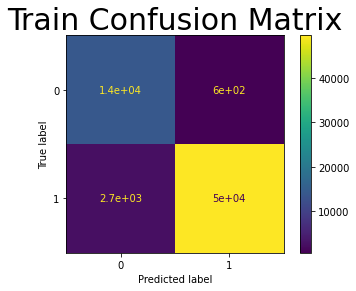

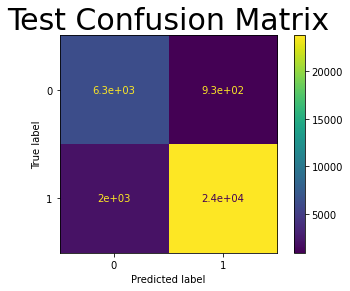

In [ ]:
classifier = SGDClassifier(penalty='l2', loss='log',alpha=0.0001, random_state=42,class_weight='balanced')
classifier.fit(x_train_bow,Y_train)

Y_predicted_train = classifier.predict(x_train_bow)
Y_predicted_test = classifier.predict(x_test_bow)

plot_confusion_matrix(classifier,x_train_bow,Y_train)
plt.title("Train Confusion Matrix",fontsize=30)
plt.show()
plot_confusion_matrix(classifier,x_test_bow,Y_test)
plt.title("Test Confusion Matrix",fontsize=30)
plt.show()

In [ ]:
print("Train F1_Score : ",f1_score(Y_train,Y_predicted_train))
print("Test F1_Score : ",f1_score(Y_test,Y_predicted_test))

Train F1_Score :  0.9682040872094159
Test F1_Score :  0.9419628689304982


In [ ]:

print("Train Accuracy : ",accuracy_score(Y_train,Y_predicted_train))
print("Test Accuracy : ",accuracy_score(Y_test,Y_predicted_test))

Train Accuracy :  0.9513615191687567
Test Accuracy :  0.9113145212620859


###<b>4.2.2 Using TFIDF 

In [ ]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(loss='log', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_tfidf, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   13.0s finished


Score from Best params :  0.9382270797874321
Best params found :  {'penalty': 'l1', 'alpha': 1e-06}
Time taken to run this cell : 0:00:25.977221


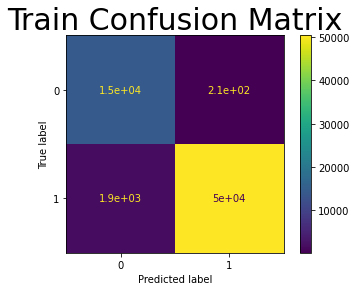

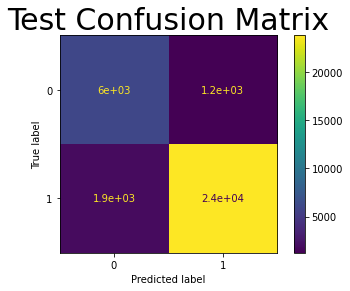

In [ ]:
classifier = SGDClassifier(penalty='l1', loss='log',alpha=0.000001, random_state=42,class_weight='balanced')
classifier.fit(x_train_tfidf,Y_train)

Y_predicted_train = classifier.predict(x_train_tfidf)
Y_predicted_test = classifier.predict(x_test_tfidf)

plot_confusion_matrix(classifier,x_train_tfidf,Y_train)
plt.title("Train Confusion Matrix",fontsize=30)
plt.show()
plot_confusion_matrix(classifier,x_test_tfidf,Y_test)
plt.title("Test Confusion Matrix",fontsize=30)
plt.show()

In [ ]:
print("Train F1_Score : ",f1_score(Y_train,Y_predicted_train))
print("Test F1_Score : ",f1_score(Y_test,Y_predicted_test))

Train F1_Score :  0.9797204020921235
Test F1_Score :  0.9375123046029058


In [ ]:

print("Train Accuracy : ",accuracy_score(Y_train,Y_predicted_train))
print("Test Accuracy : ",accuracy_score(Y_test,Y_predicted_test))

Train Accuracy :  0.9688582348023409
Test Accuracy :  0.9037977752856666


###<b>4.2.3 Using Avg-W2Vec

In [ ]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(loss='log', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_avg_w2v, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.3min finished


Score from Best params :  0.9186943429284101
Best params found :  {'penalty': 'l2', 'alpha': 0.0001}
Time taken to run this cell : 0:01:22.068793


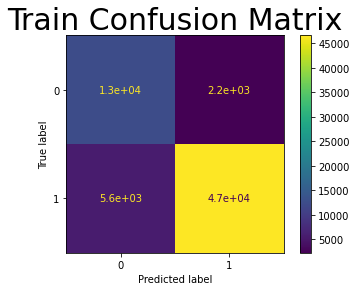

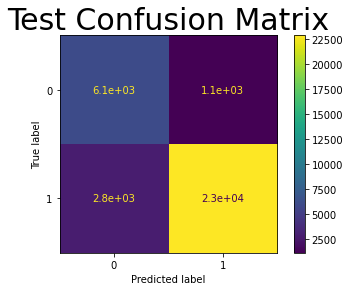

In [ ]:
classifier = SGDClassifier(penalty='l2', loss='log',alpha=0.0001, random_state=42,class_weight='balanced')
classifier.fit(x_train_avg_w2v,Y_train)

Y_predicted_train = classifier.predict(x_train_avg_w2v)
Y_predicted_test = classifier.predict(x_test_avg_w2v)

plot_confusion_matrix(classifier,x_train_avg_w2v,Y_train)
plt.title("Train Confusion Matrix",fontsize=30)
plt.show()
plot_confusion_matrix(classifier,x_test_avg_w2v,Y_test)
plt.title("Test Confusion Matrix",fontsize=30)
plt.show()

In [ ]:
print("Train F1_Score : ",f1_score(Y_train,Y_predicted_train))
print("Test F1_Score : ",f1_score(Y_test,Y_predicted_test))

Train F1_Score :  0.9224149868449685
Test F1_Score :  0.9199951780117336


In [ ]:

print("Train Accuracy : ",accuracy_score(Y_train,Y_predicted_train))
print("Test Accuracy : ",accuracy_score(Y_test,Y_predicted_test))

Train Accuracy :  0.8828974083363191
Test Accuracy :  0.8793077319431395


##<b>4.3 SVM

###<b>4.3.1 Using BOW

In [ ]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(penalty='l1', loss='hinge', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_bow, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.3min finished


Score from Best params :  0.9365650712726522
Best params found :  {'penalty': 'l2', 'alpha': 0.0001}
Time taken to run this cell : 0:01:16.899896


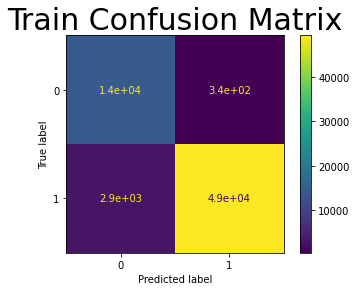

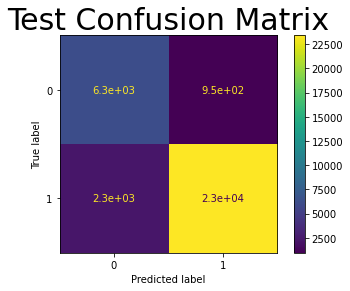

In [ ]:
classifier = SGDClassifier(penalty='l2', loss='hinge',alpha=0.0001, random_state=42,class_weight='balanced')
classifier.fit(x_train_bow,Y_train)

Y_predicted_train = classifier.predict(x_train_bow)
Y_predicted_test = classifier.predict(x_test_bow)

plot_confusion_matrix(classifier,x_train_bow,Y_train)
plt.title("Train Confusion Matrix",fontsize=30)
plt.show()
plot_confusion_matrix(classifier,x_test_bow,Y_test)
plt.title("Test Confusion Matrix",fontsize=30)
plt.show()

In [ ]:
print("Train F1_Score : ",f1_score(Y_train,Y_predicted_train))
print("Test F1_Score : ",f1_score(Y_test,Y_predicted_test))

Train F1_Score :  0.9686096896261005
Test F1_Score :  0.9345999560939589


In [ ]:

print("Train Accuracy : ",accuracy_score(Y_train,Y_predicted_train))
print("Test Accuracy : ",accuracy_score(Y_test,Y_predicted_test))

Train Accuracy :  0.9521975397109758
Test Accuracy :  0.9006759009486861


###<b>4.3.2 Using TFIDF

In [ ]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(loss='hinge', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_tfidf, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   15.3s finished


Score from Best params :  0.9383242889583469
Best params found :  {'penalty': 'l1', 'alpha': 1e-06}
Time taken to run this cell : 0:00:26.520234


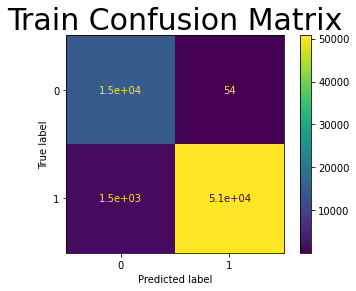

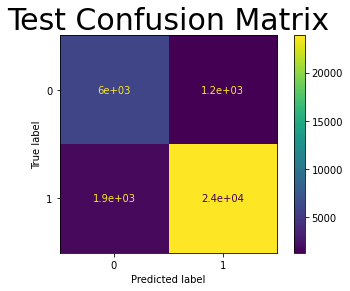

In [ ]:
classifier = SGDClassifier(penalty='l1', loss='hinge',alpha=0.000001, random_state=42,class_weight='balanced')
classifier.fit(x_train_tfidf,Y_train)

Y_predicted_train = classifier.predict(x_train_tfidf)
Y_predicted_test = classifier.predict(x_test_tfidf)

plot_confusion_matrix(classifier,x_train_tfidf,Y_train)
plt.title("Train Confusion Matrix",fontsize=30)
plt.show()
plot_confusion_matrix(classifier,x_test_tfidf,Y_test)
plt.title("Test Confusion Matrix",fontsize=30)
plt.show()

In [ ]:
print("Train F1_Score : ",f1_score(Y_train,Y_predicted_train))
print("Test F1_Score : ",f1_score(Y_test,Y_predicted_test))

Train F1_Score :  0.9848852325423466
Test F1_Score :  0.9389215435727064


In [ ]:

print("Train Accuracy : ",accuracy_score(Y_train,Y_predicted_train))
print("Test Accuracy : ",accuracy_score(Y_test,Y_predicted_test))

Train Accuracy :  0.9767407142004061
Test Accuracy :  0.9058285090776832


###<b>4.3.2 Using Avg-W2Vec

In [ ]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(penalty='l1', loss='hinge', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_avg_w2v, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.0min finished


Score from Best params :  0.9060797188880666
Best params found :  {'penalty': 'l1', 'alpha': 1e-06}
Time taken to run this cell : 0:01:30.451890


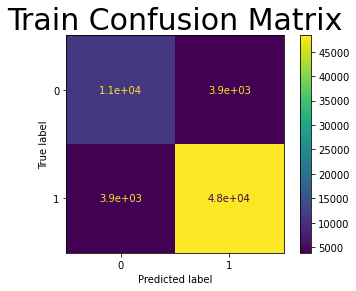

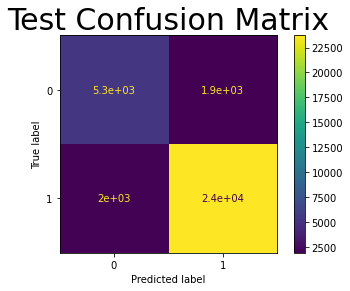

In [ ]:
classifier = SGDClassifier(penalty='l1', loss='hinge',alpha=0.000001, random_state=42,class_weight='balanced')
classifier.fit(x_train_avg_w2v,Y_train)

Y_predicted_train = classifier.predict(x_train_avg_w2v)
Y_predicted_test = classifier.predict(x_test_avg_w2v)

plot_confusion_matrix(classifier,x_train_avg_w2v,Y_train)
plt.title("Train Confusion Matrix",fontsize=30)
plt.show()
plot_confusion_matrix(classifier,x_test_avg_w2v,Y_test)
plt.title("Test Confusion Matrix",fontsize=30)
plt.show()

In [ ]:
print("Train F1_Score : ",f1_score(Y_train,Y_predicted_train))
print("Test F1_Score : ",f1_score(Y_test,Y_predicted_test))

Train F1_Score :  0.9255203048115032
Test F1_Score :  0.923241602117473


In [ ]:

print("Train Accuracy : ",accuracy_score(Y_train,Y_predicted_train))
print("Test Accuracy : ",accuracy_score(Y_test,Y_predicted_test))

Train Accuracy :  0.8838528603845694
Test Accuracy :  0.8804594914072682


##<b>4.4 RandomForest

###<b>4.4.1 Using Avg-W2Vec

In [ ]:
start = datetime.now()

n_estimators = [4, 8, 16, 32, 64, 100, 200]
max_depth = [2,5,10,15,20,30]
max_samples = [0.1,0.2,0.3]
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
max_features = ['sqrt','log2']

random_grid = {
    'n_estimators':n_estimators,
    'max_depth' : max_depth,
    'max_samples' : max_samples,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'max_features' : max_features
}

classifier = RandomForestClassifier(class_weight='balanced',n_jobs=-1)

randCV = RandomizedSearchCV(classifier, param_distributions = random_grid, n_iter = 100, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_avg_w2v, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 39

Score from Best params :  0.9217811191165172
Best params found :  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.3, 'max_features': 'sqrt', 'max_depth': 15}
Time taken to run this cell : 1:15:19.756094


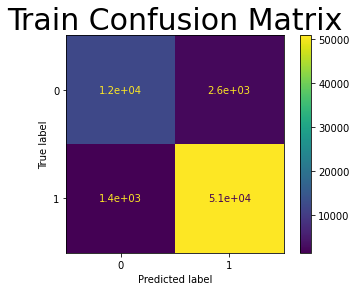

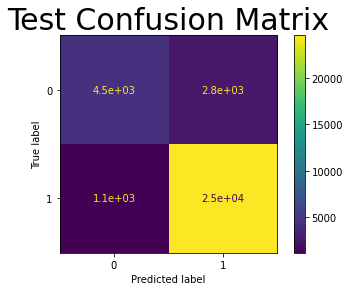

In [ ]:
classifier = RandomForestClassifier(class_weight='balanced',n_estimators= 200, min_samples_split= 5, min_samples_leaf = 4, max_samples = 0.3, max_features = 'sqrt', max_depth = 15,n_jobs=-1)
classifier.fit(x_train_avg_w2v,Y_train)

Y_predicted_train = classifier.predict(x_train_avg_w2v)
Y_predicted_test = classifier.predict(x_test_avg_w2v)

plot_confusion_matrix(classifier,x_train_avg_w2v,Y_train)
plt.title("Train Confusion Matrix",fontsize=30)
plt.show()
plot_confusion_matrix(classifier,x_test_avg_w2v,Y_test)
plt.title("Test Confusion Matrix",fontsize=30)
plt.show()

In [ ]:
print("Train F1_Score : ",f1_score(Y_train,Y_predicted_train))
print("Test F1_Score : ",f1_score(Y_test,Y_predicted_test))

Train F1_Score :  0.9621027126280121
Test F1_Score :  0.9265555869340111


In [ ]:

print("Train Accuracy : ",accuracy_score(Y_train,Y_predicted_train))
print("Test Accuracy : ",accuracy_score(Y_test,Y_predicted_test))

Train Accuracy :  0.9402245312313389
Test Accuracy :  0.8817627981693087


###<b>4.4.2 TFIDF - W2Vec

In [ ]:
start = datetime.now()

n_estimators = [4, 8, 16, 32, 64, 100, 200]
max_depth = [2,5,10,15,20,30]
max_samples = [0.1,0.2,0.3]
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
max_features = ['sqrt','log2']

random_grid = {
    'n_estimators':n_estimators,
    'max_depth' : max_depth,
    'max_samples' : max_samples,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'max_features' : max_features
}

classifier = RandomForestClassifier(class_weight='balanced',n_jobs=-1)

randCV = RandomizedSearchCV(classifier, param_distributions = random_grid, n_iter = 50, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_tfidf_w2v, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 39

Score from Best params :  0.9152286133823244
Best params found :  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': 0.3, 'max_features': 'sqrt', 'max_depth': 30}
Time taken to run this cell : 0:41:39.747329


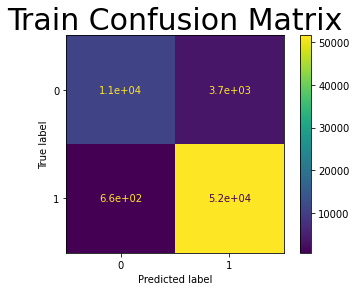

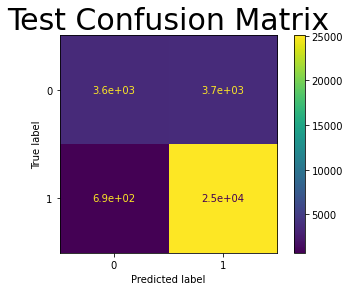

In [ ]:
classifier = RandomForestClassifier(class_weight='balanced',n_estimators= 100, min_samples_split= 10, min_samples_leaf = 4, max_samples = 0.3, max_features = 'sqrt', max_depth = 30,n_jobs=-1)
classifier.fit(x_train_tfidf_w2v,Y_train)

Y_predicted_train = classifier.predict(x_train_tfidf_w2v)
Y_predicted_test = classifier.predict(x_test_tfidf_w2v)

plot_confusion_matrix(classifier,x_train_tfidf_w2v,Y_train)
plt.title("Train Confusion Matrix",fontsize=30)
plt.show()
plot_confusion_matrix(classifier,x_test_tfidf_w2v,Y_test)
plt.title("Test Confusion Matrix",fontsize=30)
plt.show()

In [ ]:
print("Train F1_Score : ",f1_score(Y_train,Y_predicted_train))
print("Test F1_Score : ",f1_score(Y_test,Y_predicted_test))

Train F1_Score :  0.9593879846438431
Test F1_Score :  0.9202321054757796


In [ ]:

print("Train Accuracy : ",accuracy_score(Y_train,Y_predicted_train))
print("Test Accuracy : ",accuracy_score(Y_test,Y_predicted_test))

Train Accuracy :  0.9347754687686611
Test Accuracy :  0.868335707574334


In [ ]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(loss='log', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_bow, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.4min finished


Score from Best params :  0.94021306250761
Best params found :  {'penalty': 'l2', 'alpha': 0.0001}
Time taken to run this cell : 0:01:24.537364


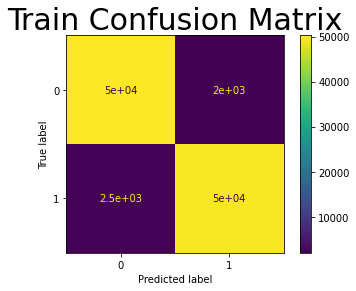

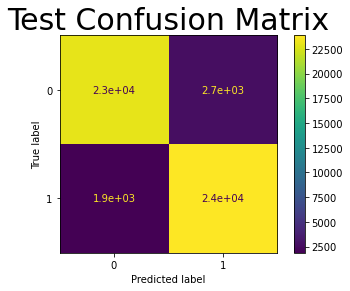

In [ ]:
classifier = SGDClassifier(penalty='l2', loss='log',alpha=0.0001, random_state=42,class_weight='balanced')
classifier.fit(x_train_bow,Y_train)

Y_predicted_train = classifier.predict(x_train_bow)
Y_predicted_test = classifier.predict(x_test_bow)

plot_confusion_matrix(classifier,x_train_bow,Y_train)
plt.title("Train Confusion Matrix",fontsize=30)
plt.show()
plot_confusion_matrix(classifier,x_test_bow,Y_test)
plt.title("Test Confusion Matrix",fontsize=30)
plt.show()

In [ ]:
print("Train F1_Score : ",f1_score(Y_train,Y_predicted_train))
print("Test F1_Score : ",f1_score(Y_test,Y_predicted_test))


Train F1_Score :  0.9597820247140992
Test F1_Score :  0.914518524159464


In [ ]:

print("Train Accuracy : ",accuracy_score(Y_train,Y_predicted_train))
print("Test Accuracy : ",accuracy_score(Y_test,Y_predicted_test))

Train Accuracy :  0.9598959130567886
Test Accuracy :  0.9127918269044012


In [ ]:
print("Train F1_Score : ",precision_score(Y_train,Y_predicted_train))
print("Test F1_Score : ",precision_score(Y_test,Y_predicted_test))


Train F1_Score :  0.9615132087131161
Test F1_Score :  0.8995516370897856
